In [3]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
class ThreeLayerMLP(nn.Module):

    def __init__(self):
        super(ThreeLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [6]:
def train_epoch(dataloader, model, criterion, optimizer, regularizer):
    
    size = len(dataloader.dataset)
    
    for batchnum, (X, y) in enumerate(dataloader):
        yhat = model(X)
        loss = criterion(yhat, y)
        loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0:
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validate(dataloader, model, criterion, regularizer):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss += regularizer(model)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [7]:
def reg_WD(model):
    res = 0
    lmb = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

def train(model, reg):
    lr = 1e-2
    batch_size = 256
    epochs = 20

    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=1)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    
    accuracy = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train()
        train_epoch(train_loader, model, criterion, optimizer, reg)
        model.eval()
        accuracy.append(validate(test_loader, model, criterion, reg))


    print("Done!")
    return accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = ThreeLayerMLP().to(device)
baseWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.309232  [    0/60000]
loss: 0.476187  [25600/60000]
loss: 0.405294  [51200/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.434638 

Epoch 2
-------------------------------
loss: 0.414130  [    0/60000]
loss: 0.356377  [25600/60000]
loss: 0.387729  [51200/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.415161 

Epoch 3
-------------------------------
loss: 0.399574  [    0/60000]
loss: 0.333354  [25600/60000]
loss: 0.269808  [51200/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.383263 

Epoch 4
-------------------------------
loss: 0.341483  [    0/60000]
loss: 0.320092  [25600/60000]
loss: 0.400297  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.386103 

Epoch 5
-------------------------------
loss: 0.275931  [    0/60000]
loss: 0.269901  [25600/60000]
loss: 0.372274  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.368593 

Epoch 6
-------------------------------
loss: 0.319681  [    0/60000]
loss: 0.403294  [256

In [9]:
def reg_WD(model):
    res = 0
    lmb = 1e-4
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

model = ThreeLayerMLP().to(device)
largeWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.308640  [    0/60000]
loss: 0.544218  [25600/60000]
loss: 0.546245  [51200/60000]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.446654 

Epoch 2
-------------------------------
loss: 0.368305  [    0/60000]
loss: 0.450171  [25600/60000]
loss: 0.391035  [51200/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.423330 

Epoch 3
-------------------------------
loss: 0.319521  [    0/60000]
loss: 0.444112  [25600/60000]
loss: 0.465020  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.398057 

Epoch 4
-------------------------------
loss: 0.392437  [    0/60000]
loss: 0.385780  [25600/60000]
loss: 0.369274  [51200/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.444979 

Epoch 5
-------------------------------
loss: 0.539151  [    0/60000]
loss: 0.357010  [25600/60000]
loss: 0.530913  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.408883 

Epoch 6
-------------------------------
loss: 0.428310  [    0/60000]
loss: 0.322601  [256

In [10]:
def reg_WD(model):
    res = 0
    lmb = 1e-6
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

model = ThreeLayerMLP().to(device)
smallWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.313468  [    0/60000]
loss: 0.441425  [25600/60000]
loss: 0.399067  [51200/60000]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.475250 

Epoch 2
-------------------------------
loss: 0.446217  [    0/60000]
loss: 0.385894  [25600/60000]
loss: 0.384252  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.392647 

Epoch 3
-------------------------------
loss: 0.310266  [    0/60000]
loss: 0.373923  [25600/60000]
loss: 0.457356  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.391630 

Epoch 4
-------------------------------
loss: 0.399330  [    0/60000]
loss: 0.343786  [25600/60000]
loss: 0.331549  [51200/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.375641 

Epoch 5
-------------------------------
loss: 0.303029  [    0/60000]
loss: 0.367301  [25600/60000]
loss: 0.354364  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.390886 

Epoch 6
-------------------------------
loss: 0.330841  [    0/60000]
loss: 0.270698  [256

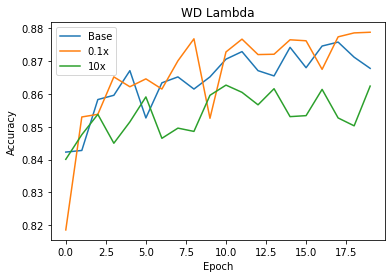

In [11]:
plt.plot(baseWD,label="Base")
plt.plot(smallWD,label="0.1x")
plt.plot(largeWD,label="10x")

plt.title("WD Lambda")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = ThreeLayerMLP().to(device)
baseWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.301508  [    0/60000]
loss: 0.432641  [25600/60000]
loss: 0.459142  [51200/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.447726 

Epoch 2
-------------------------------
loss: 0.463196  [    0/60000]
loss: 0.319892  [25600/60000]
loss: 0.332726  [51200/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.407081 

Epoch 3
-------------------------------
loss: 0.320237  [    0/60000]
loss: 0.353334  [25600/60000]
loss: 0.309535  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.380121 

Epoch 4
-------------------------------
loss: 0.391372  [    0/60000]
loss: 0.308135  [25600/60000]
loss: 0.309461  [51200/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.370619 

Epoch 5
-------------------------------
loss: 0.319211  [    0/60000]
loss: 0.468226  [25600/60000]
loss: 0.309763  [51200/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.369849 

Epoch 6
-------------------------------
loss: 0.336683  [    0/60000]
loss: 0.307425  [256

In [13]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-5
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = ThreeLayerMLP().to(device)
largeEWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.299420  [    0/60000]
loss: 0.471984  [25600/60000]
loss: 0.404510  [51200/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.426833 

Epoch 2
-------------------------------
loss: 0.341214  [    0/60000]
loss: 0.395300  [25600/60000]
loss: 0.354358  [51200/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.397757 

Epoch 3
-------------------------------
loss: 0.309298  [    0/60000]
loss: 0.367052  [25600/60000]
loss: 0.352943  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.380793 

Epoch 4
-------------------------------
loss: 0.250468  [    0/60000]
loss: 0.243143  [25600/60000]
loss: 0.329664  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.383019 

Epoch 5
-------------------------------
loss: 0.342618  [    0/60000]
loss: 0.265198  [25600/60000]
loss: 0.297682  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.374663 

Epoch 6
-------------------------------
loss: 0.262877  [    0/60000]
loss: 0.272031  [256

In [14]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-7
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = ThreeLayerMLP().to(device)
smallEWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.309095  [    0/60000]
loss: 0.442082  [25600/60000]
loss: 0.328547  [51200/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.427118 

Epoch 2
-------------------------------
loss: 0.512814  [    0/60000]
loss: 0.436190  [25600/60000]
loss: 0.421403  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.397471 

Epoch 3
-------------------------------
loss: 0.340497  [    0/60000]
loss: 0.292322  [25600/60000]
loss: 0.326148  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.395938 

Epoch 4
-------------------------------
loss: 0.294016  [    0/60000]
loss: 0.333233  [25600/60000]
loss: 0.366599  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.376197 

Epoch 5
-------------------------------
loss: 0.308193  [    0/60000]
loss: 0.388449  [25600/60000]
loss: 0.319883  [51200/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.384496 

Epoch 6
-------------------------------
loss: 0.400262  [    0/60000]
loss: 0.265774  [256

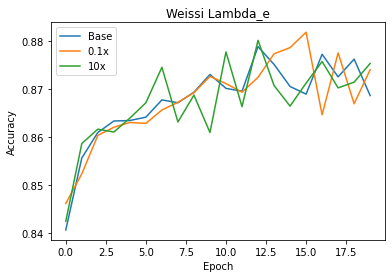

In [15]:
plt.plot(baseWeissi,label="Base")
plt.plot(smallEWeissi,label="0.1x")
plt.plot(largeEWeissi,label="10x")

plt.title("Weissi Lambda_e")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-4
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = ThreeLayerMLP().to(device)
largeCWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.308736  [    0/60000]
loss: 0.585315  [25600/60000]
loss: 0.364631  [51200/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.420745 

Epoch 2
-------------------------------
loss: 0.452194  [    0/60000]
loss: 0.387361  [25600/60000]
loss: 0.384534  [51200/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.418446 

Epoch 3
-------------------------------
loss: 0.348422  [    0/60000]
loss: 0.321061  [25600/60000]
loss: 0.245321  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.385215 

Epoch 4
-------------------------------
loss: 0.304987  [    0/60000]
loss: 0.445180  [25600/60000]
loss: 0.354807  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.372958 

Epoch 5
-------------------------------
loss: 0.316596  [    0/60000]
loss: 0.265531  [25600/60000]
loss: 0.283188  [51200/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.436330 

Epoch 6
-------------------------------
loss: 0.337435  [    0/60000]
loss: 0.304326  [256

In [17]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-6
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = ThreeLayerMLP().to(device)
smallCWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.292824  [    0/60000]
loss: 0.397837  [25600/60000]
loss: 0.403125  [51200/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.453231 

Epoch 2
-------------------------------
loss: 0.467424  [    0/60000]
loss: 0.380554  [25600/60000]
loss: 0.389014  [51200/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.382559 

Epoch 3
-------------------------------
loss: 0.325761  [    0/60000]
loss: 0.343040  [25600/60000]
loss: 0.339706  [51200/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.387871 

Epoch 4
-------------------------------
loss: 0.288290  [    0/60000]
loss: 0.251564  [25600/60000]
loss: 0.289708  [51200/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.364377 

Epoch 5
-------------------------------
loss: 0.309992  [    0/60000]
loss: 0.361274  [25600/60000]
loss: 0.263944  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.396577 

Epoch 6
-------------------------------
loss: 0.410950  [    0/60000]
loss: 0.328907  [256

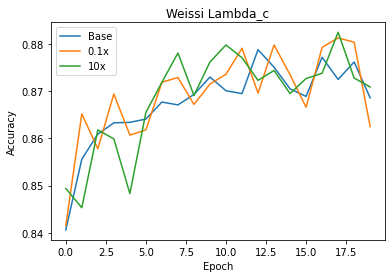

In [18]:
plt.plot(baseWeissi,label="Base")
plt.plot(smallCWeissi,label="0.1x")
plt.plot(largeCWeissi,label="10x")

plt.title("Weissi Lambda_c")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
class ThreeLayerMLP(nn.Module):

    def __init__(self, l1, l2):
        super(ThreeLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, l1),
            nn.ReLU(),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Linear(l2, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [20]:
model = ThreeLayerMLP(100,100).to(device)
oneWD = train(model, reg_WD)
model = ThreeLayerMLP(100,100).to(device)
oneWeissi =  train(model, weissi)

Epoch 1
-------------------------------
loss: 2.300931  [    0/60000]
loss: 0.525052  [25600/60000]
loss: 0.454014  [51200/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.435273 

Epoch 2
-------------------------------
loss: 0.370837  [    0/60000]
loss: 0.368070  [25600/60000]
loss: 0.421181  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.387447 

Epoch 3
-------------------------------
loss: 0.418576  [    0/60000]
loss: 0.230544  [25600/60000]
loss: 0.385591  [51200/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.376386 

Epoch 4
-------------------------------
loss: 0.265654  [    0/60000]
loss: 0.260888  [25600/60000]
loss: 0.295377  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.382863 

Epoch 5
-------------------------------
loss: 0.342559  [    0/60000]
loss: 0.293213  [25600/60000]
loss: 0.275225  [51200/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.404430 

Epoch 6
-------------------------------
loss: 0.387812  [    0/60000]
loss: 0.404782  [256

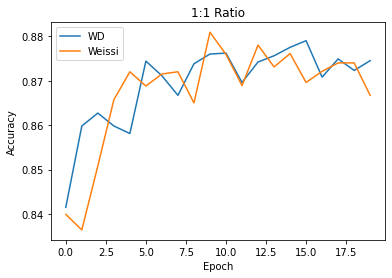

In [21]:
plt.plot(oneWD,label="WD")
plt.plot(oneWeissi,label="Weissi")

plt.title("1:1 Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
model = ThreeLayerMLP(100,50).to(device)
twoWD = train(model, reg_WD)
model = ThreeLayerMLP(100,50).to(device)
twoWeissi =  train(model, weissi)

Epoch 1
-------------------------------
loss: 2.306704  [    0/60000]
loss: 0.436415  [25600/60000]
loss: 0.405812  [51200/60000]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.429057 

Epoch 2
-------------------------------
loss: 0.368414  [    0/60000]
loss: 0.331771  [25600/60000]
loss: 0.272564  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.407242 

Epoch 3
-------------------------------
loss: 0.423285  [    0/60000]
loss: 0.377252  [25600/60000]
loss: 0.296214  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.392365 

Epoch 4
-------------------------------
loss: 0.390476  [    0/60000]
loss: 0.314449  [25600/60000]
loss: 0.310510  [51200/60000]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.359988 

Epoch 5
-------------------------------
loss: 0.349116  [    0/60000]
loss: 0.312895  [25600/60000]
loss: 0.368971  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.370382 

Epoch 6
-------------------------------
loss: 0.280654  [    0/60000]
loss: 0.319338  [256

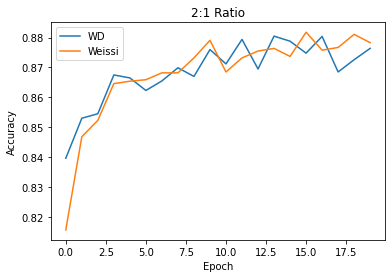

In [23]:
plt.plot(twoWD,label="WD")
plt.plot(twoWeissi,label="Weissi")

plt.title("2:1 Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [24]:
model = ThreeLayerMLP(200,50).to(device)
fourWD = train(model, reg_WD)
model = ThreeLayerMLP(200,50).to(device)
fourWeissi =  train(model, weissi)

Epoch 1
-------------------------------
loss: 2.311703  [    0/60000]
loss: 0.585461  [25600/60000]
loss: 0.457347  [51200/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.427315 

Epoch 2
-------------------------------
loss: 0.369765  [    0/60000]
loss: 0.303539  [25600/60000]
loss: 0.477729  [51200/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.467060 

Epoch 3
-------------------------------
loss: 0.423304  [    0/60000]
loss: 0.269634  [25600/60000]
loss: 0.378337  [51200/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.388475 

Epoch 4
-------------------------------
loss: 0.323560  [    0/60000]
loss: 0.319576  [25600/60000]
loss: 0.364199  [51200/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.362598 

Epoch 5
-------------------------------
loss: 0.265796  [    0/60000]
loss: 0.368137  [25600/60000]
loss: 0.257101  [51200/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.364033 

Epoch 6
-------------------------------
loss: 0.303418  [    0/60000]
loss: 0.254440  [256

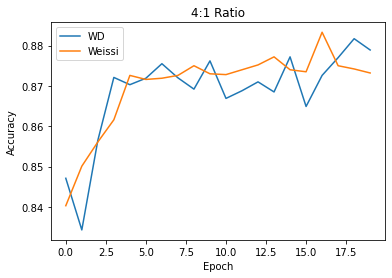

In [25]:
plt.plot(fourWD,label="WD")
plt.plot(fourWeissi,label="Weissi")

plt.title("4:1 Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
model = ThreeLayerMLP(400,50).to(device)
eightWD = train(model, reg_WD)
model = ThreeLayerMLP(400,50).to(device)
eightWeissi =  train(model, weissi)

Epoch 1
-------------------------------
loss: 2.300932  [    0/60000]
loss: 0.458466  [25600/60000]
loss: 0.282508  [51200/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.419414 

Epoch 2
-------------------------------
loss: 0.428620  [    0/60000]
loss: 0.416687  [25600/60000]
loss: 0.419676  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.394161 

Epoch 3
-------------------------------
loss: 0.377892  [    0/60000]
loss: 0.360130  [25600/60000]
loss: 0.381821  [51200/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.375282 

Epoch 4
-------------------------------
loss: 0.340764  [    0/60000]
loss: 0.306284  [25600/60000]
loss: 0.383214  [51200/60000]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.364765 

Epoch 5
-------------------------------
loss: 0.241618  [    0/60000]
loss: 0.290195  [25600/60000]
loss: 0.300418  [51200/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.389019 

Epoch 6
-------------------------------
loss: 0.273534  [    0/60000]
loss: 0.302069  [256

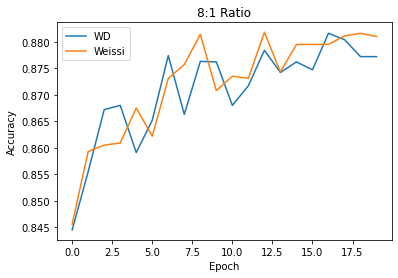

In [27]:
plt.plot(eightWD,label="WD")
plt.plot(eightWeissi,label="Weissi")

plt.title("8:1 Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
model = ThreeLayerMLP(800,50).to(device)
sixteenWD = train(model, reg_WD)
model = ThreeLayerMLP(800,50).to(device)
sixteenWeissi =  train(model, weissi)

Epoch 1
-------------------------------
loss: 2.305032  [    0/60000]
loss: 0.503316  [25600/60000]
loss: 0.395114  [51200/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.435569 

Epoch 2
-------------------------------
loss: 0.335608  [    0/60000]
loss: 0.434562  [25600/60000]
loss: 0.443983  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.404199 

Epoch 3
-------------------------------
loss: 0.366845  [    0/60000]
loss: 0.341179  [25600/60000]
loss: 0.299152  [51200/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.423945 

Epoch 4
-------------------------------
loss: 0.329201  [    0/60000]
loss: 0.356614  [25600/60000]
loss: 0.430349  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.373311 

Epoch 5
-------------------------------
loss: 0.359106  [    0/60000]
loss: 0.320537  [25600/60000]
loss: 0.272069  [51200/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.374734 

Epoch 6
-------------------------------
loss: 0.273622  [    0/60000]
loss: 0.226851  [256

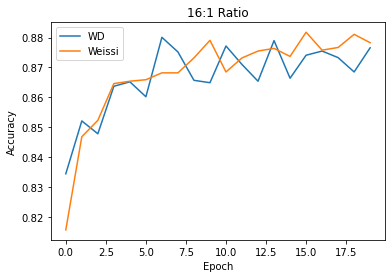

In [29]:
plt.plot(sixteenWD,label="WD")
plt.plot(twoWeissi,label="Weissi")

plt.title("16:1 Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()